In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import glob
import pandas as pd
import matplotlib 
from astropy.table import Table
import scipy.signal as sp

In [3]:
# define a funtion to return 0 when divided by zero
def div0( a, b, fill=0. ):
    """ a / b, divide by 0 -> `fill`
        div0( [-1, 0, 1], 0, fill=np.nan) -> [nan nan nan]
        div0( 1, 0, fill=np.inf ) -> inf
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
    if np.isscalar( c ):
        return c if np.isfinite( c ) \
            else fill
    else:
        c[ ~ np.isfinite( c )] = fill
        return c

def normalize(data):
    return ((data - np.min(data)) / (np.max(data) - np.min(data))) + 1


def df2array(df):
    lists = []
    for i in range(len(df)):
        lists.append(df.iloc[i][0])
    return np.array(lists)


# define a function that resamples the data based on wavelength
# has 3 1darray inputs: target_array is the array that has the sampling you want;
# ref_array is the array that has the same kind of data with the target_array but with different sampling rate:
# and the input_array is the array sharing the same sampling rate but not necessicirally the same data with the ref_array

# this function resamlpes the ref_array to the same sampling as the target_array first and then
# use the indecies to resample the input array, output is the resampled input_array


def resampling(target_array, ref_array, input_array, resamp_ref_array=False):

    # for each value in the target_array, find the indeices of the value(s)
    # nearest to it in the ref_array, output has the same legth as the target_array
    index = abs(target_array[:, None] - ref_array[None, :]).argmin(axis=-1)

    # based on the indices find the corresponding values in the input_array and
    # write everything into a new array
    resampled_array = []
    for i in index:
        resampled_array.append(input_array[i])

    # choose if to output the resampled ref_array, sometimes you need this
    if resamp_ref_array == True:
        resampled_ref_array = []
        for i in index:
            resampled_ref_array.append(ref_array[i])
        return resampled_array, resampled_ref_array
    else:
        return resampled_array


def find_files(date, name):

    spec1d_list = glob.glob('NIRES_PypeIt/' + date + '_reduced' + '/Science/' +
                            'spec1d*.fits')
    target_files = []
    for i in range(len(spec1d_list)):
        if name in spec1d_list[i]:
            target_files.append(spec1d_list[i])
    return target_files

def stack_1order(frame_list, order):
    all_flux = []
    all_ivar = []
    all_wave = []
    for frame_id in range(len(frame_list)):
        hdul = fits.open(frame_list[frame_id])
        data = hdul[order].data
        all_flux.append(data['OPT_COUNTS'])
        all_ivar.append(data['OPT_COUNTS_IVAR'])
        all_wave.append(data['OPT_WAVE'])
        hdul.close()
    stacked_flux = np.median(all_flux, axis=0)
    
    stacked_var  = np.sum(div0(1,all_ivar),axis=0)/np.square(len(all_ivar[0]))
    stacked_ivar = div0(1,stacked_var)
    stacked_wave = np.median(all_wave, axis=0)

    stacked_data = [stacked_wave, stacked_flux, stacked_ivar]
    return stacked_data

In [4]:
# specifiy which date to work with
date = '20180630'

# read the model data
A0_model = pd.read_csv('NIRES_PypeIt/A0V.dat',
                       skiprows=2,
                       header=None,
                       names=['lk', 'ukf_a0v', 'uks_a0v', 'fh', 'fl', 'fc'],
                       sep='  ',
                       engine='python')

A0_flux = df2array(A0_model[['ukf_a0v']])
A0_wave = df2array(A0_model[['lk']])

sci_files = find_files(date, 'J1203+1807')

In [5]:
def plot_order(order):
    
    sci_hdul = fits.open(sci_files[0])

    # define the science and telluric wave and flux
    sci_data = sci_hdul[order + 1].data

    sci_wave, sci_flux = sci_data['OPT_WAVE'], sci_data['OPT_COUNTS']
    sci_ivar = sci_data['OPT_COUNTS_IVAR']
    sci_sig = sci_data['OPT_COUNTS_SIG']

    tell_wave, tell_flux = np.array(all_stacked_tell[order][0]), np.array(
        all_stacked_tell[order][1])

    # resample telluric data to science data
    tell_flux, tell_wave = resampling(sci_wave,
                                      tell_wave,
                                      tell_flux,
                                      resamp_ref_array=True)

    # slice model wavelength to make it in the same range
    # as the wavelenghth range of the working order
    A0_lo = np.abs(A0_wave - sci_wave[0]).argmin()
    A0_up = np.abs(A0_wave - sci_wave[-1]).argmin()
    A0_wave_sliced = A0_wave[A0_lo:A0_up]
    A0_flux_sliced = A0_flux[A0_lo:A0_up]
    # resample the model data to the same rate as the science data
    A0_flux_sliced, A0_wave_sliced = resampling(sci_wave,
                                                A0_wave_sliced,
                                                A0_flux_sliced,
                                                resamp_ref_array=True)

    # perform the correction
    tellcorr_sci = np.multiply(sci_flux, div0(A0_flux_sliced, tell_flux))

    # rescale (not propograte) the error
    tellcorr_sci_sig = np.multiply(sci_sig, div0(A0_flux_sliced, tell_flux))
    
    return sci_wave,A0_flux_sliced,tell_flux, sci_flux


# specifiy which date to work with
date = '20180630'

tell_files = find_files(date, 'HIP64248')

# stak_1order data structure: DTYPE0 = wavelength; DTYPE1 = flux (counts)
# there are ORDER0007 to ORDER0003 5 orders
# actually index of the hdul each order correspond to
all_stacked_tell = []
# range(1,6) corresponds to hudl[1] to hdul[5] corresponds to the 5 orders
for i in range(1, 6):
    all_stacked_tell.append(stack_1order(tell_files, i))

In [6]:
peak_coords = [9546,10050, 10942, 12685, 12820]
sci_wave = plot_order(0)[0]

tellcorr_factor = div0(plot_order(0)[1], plot_order(0)[2])
# interpolate the pachen series peaks
for peak_coord in peak_coords:
    # if the wavelength is in the range of the order
    if peak_coord >= sci_wave[0] and peak_coord <= sci_wave[-1]:
        # find the x index of the peak and use it to find width
        given_peak_id = abs(peak_coord - sci_wave).argmin()
        peak_range_id = np.linspace(given_peak_id - 3,
                                    given_peak_id + 3,
                                    7,
                                    dtype=int)
        
        peak_range_values = []
        for i in peak_range_id:
            peak_range_values.append(tellcorr_factor[i])
            
        peak_id = [peak_range_id[np.array(peak_range_values).argmax()]]
        peak_width = sp.peak_widths(tellcorr_factor, peak_id,
                                    rel_height=0.85)[0]
        # find the index of the right and left limit of the peak
        # assume symmetry
        right_id = peak_id[0] + round(peak_width[0] / 2)
        left_id = peak_id[0] - round(peak_width[0] / 2)
        width = right_id - left_id
        # the left and right x indices around the peak,
        # used to interpolate new values for the peak region
        xp = np.hstack((np.linspace(left_id - width,
                                    left_id - 1,
                                    width,
                                    dtype=int),
                        np.linspace(right_id + 1,
                                    right_id + width,
                                    width,
                                    dtype=int)))
        # the corresponding y values
        fp = []
        for i in xp:
            fp.append(tellcorr_factor[i])
        # interpolate range (the width of the peak)
        x_interp = np.linspace(left_id, right_id, width + 1, dtype=int)
        # interpolate
        interp_y = np.interp(x_interp, xp, fp)
        # rewrite and replace
        for i in range(len(x_interp)):
            tellcorr_factor[x_interp[i]] = interp_y[i]
    else:
        pass

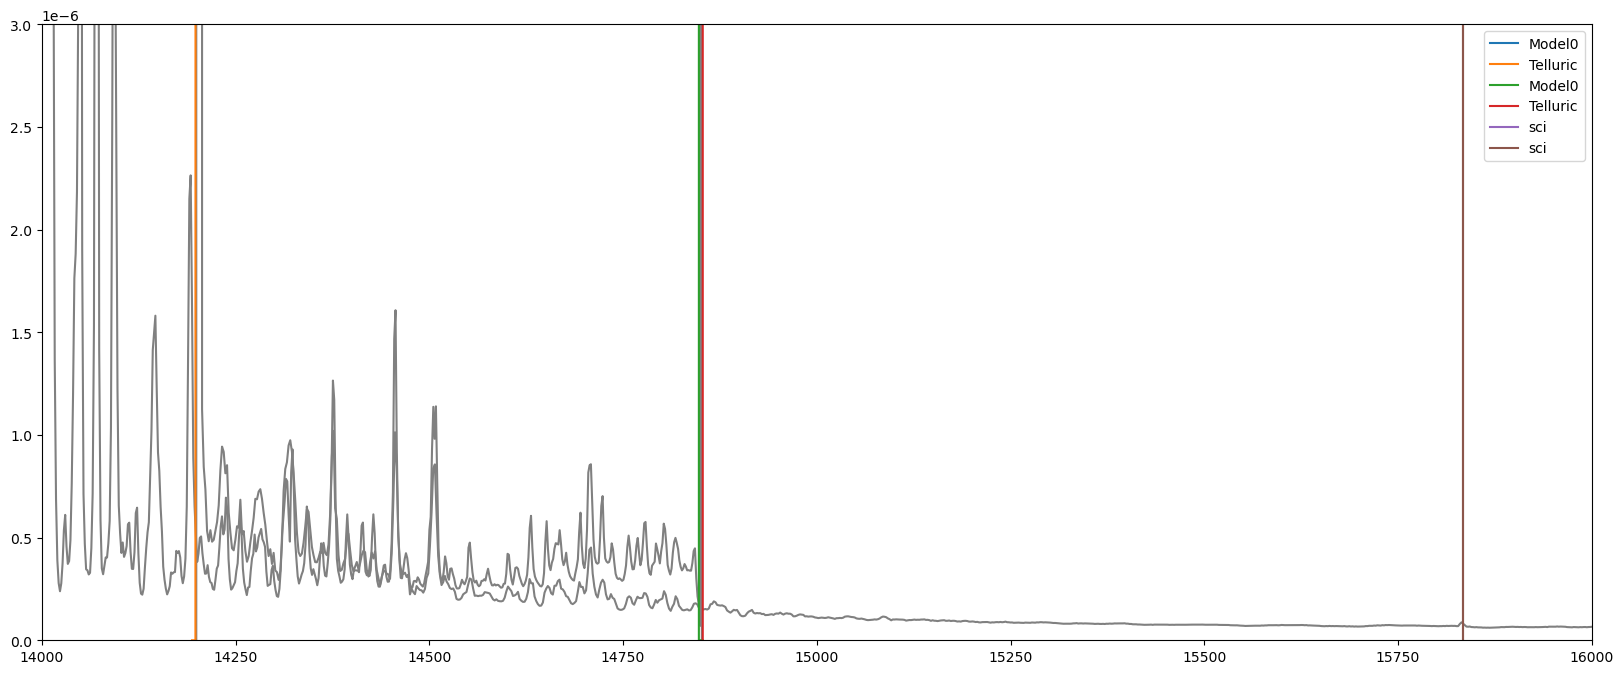

In [7]:
plt.figure(figsize=(20, 8))
plt.plot(plot_order(4)[0],div0(plot_order(4)[1], plot_order(4)[2]),c='grey')
plt.plot(plot_order(3)[0],div0(plot_order(3)[1], plot_order(3)[2]),c='grey')
plt.plot(plot_order(2)[0],div0(plot_order(2)[1], plot_order(2)[2]),c='grey')
plt.plot(plot_order(1)[0], div0(plot_order(1)[1], plot_order(1)[2]), c='grey')
plt.plot(plot_order(0)[0], div0(plot_order(0)[1], plot_order(0)[2]), c='grey')

plt.plot(plot_order(3)[0],normalize(plot_order(3)[1])-1,label='Model0')
plt.plot(plot_order(3)[0],normalize(plot_order(3)[2])-1,label='Telluric')

plt.plot(plot_order(2)[0],normalize(plot_order(2)[1])-1,label='Model0')
plt.plot(plot_order(2)[0],normalize(plot_order(2)[2])-1,label='Telluric')

plt.plot(plot_order(2)[0],normalize(plot_order(2)[3])-1,label='sci')
plt.plot(plot_order(3)[0],normalize(plot_order(3)[3])-1,label='sci')

#plt.plot(plot_order(1)[0],plot_order(1)[1],label='Model1')
#plt.plot(plot_order(1)[0],normalize(plot_order(1)[2])-1,label='Telluric')

plt.vlines(12820,ymax=2,ymin=0) # Paschen 5 to 3
plt.vlines(10942, ymax=2, ymin=0)  # Paschen 6 to 3
plt.vlines(10052, ymax=2, ymin=0)  # Paschen 7 to 3
plt.vlines(12685,ymax=2,ymin=0)
plt.vlines(9546,ymax=2,ymin=0)

#plt.vlines(12692,ymax=2,ymin=0,colors='red')
#plt.vlines(12678,ymax=2,ymin=0,colors='red')

#plt.vlines(12840,ymax=2,ymin=0,colors='red')
#plt.vlines(12799,ymax=2,ymin=0,colors='red')

#plt.plot(plot_order(0)[0], tellcorr_factor, c='orange')
#plt.vlines(20022,ymax=2,ymin=0)
plt.xlim(14000, 16000)
plt.ylim(-0.0000, 0.000003)
plt.legend()

In [ ]:
# specifiy which date to work with
date = '20180630'

tell_files = find_files(date, 'HIP')

tell_airmass_list = []
for frame_id in range(len(tell_files)):
    hdul = fits.open(tell_files[frame_id])
    hdr = hdul[0].header
    tell_airmass.append(hdr['AIRMASS'])
    hdul.close()
tell_airmass_list = np.array(tell_airmass)

# caculate the airmass difference
airmass_diff = tell_airmass_list - 1.02
print(airmass_diff)

# determine which frame(s) to use
# if all positive, i.e. all tell airmass greater than the sci airmass
if min(airmass_diff >= 0):
    tell1_id = airmass_diff.argmin()
    tell1_path = tell_files[tell1_id]
    tell2_path = 'None'
# if all negative, i.e. all tell airmass smaller than the sci airmass
elif max(airmass_diff < 0):
    tell1_id = airmass_diff.argmax()
    tell1_path = tell_files[tell1_id]
    tell2_path = 'None'
# when in between
else:
    # tell1 is the frame with greater airmass
    # tell2 is the frame with smaller airmass
    tell1_id = airmass_diff.index(min(i for i in airmass_diff if i > 0))
    tell2_id = airmass_diff.index(min(i for i in airmass_diff if i < 0))
    tell1_airmass = tell_airmass_list[tell1_id]
    tell2_airmass = tell_airmass_list[tell2_id]
    tell1_path = tell_files[tell1_id]
    tell2_path = tell_files[tell2_id]
    # weight of the two telluric frames based on 
    # airmass relative to science airmass
    weight1 = abs(tell2_airmass-sci_airmass)
    weight2 = abs(tell1_airmass-sci_airmass)
    
    # if the airmass of the sci frame is not in between two telluric arimasses,
    # then just use one telluric
    if tell2_path == 'None':
        tell_hdul = fits.open(tell1_path)
        tell_data = tell_hdul[order].data
        tell_wave, tell_flux = tell_data['OPT_WAVE'], tell_data['OPT_COUNTS']
        tell_hdul.close()
        tell_flux = resampling(sci_wave, tell_wave, tell_flux)

    # if the airmass of the sci frame is in between two telluric arimasses,
    # then caculate the weighted mean of the two telluric flux
    else:
        tell1_hdul = fits.open(tell1_path)
        tell2_hdul = fits.open(tell2_path)

        tell1_wave, tell1_flux = tell1_hdul[order].data['OPT_WAVE'], tell1_hdul[
            order].data['OPT_COUNTS']
        tell2_wave, tell2_flux = tell2_hdul[order].data['OPT_WAVE'], tell2_hdul[
            order].data['OPT_COUNTS']

        tell1_hdul.close()
        tell2_hdul.close()

        tell1_flux = resampling(sci_wave, tell1_wave, tell1_flux)
        tell2_flux = resampling(sci_wave, tell2_wave, tell2_flux)

        tell_flux = (tell1_flux*weight1 + tell2_flux*weight2)/(weight1+weight2)